<img src="../thumbnail.svg" width=250 alt="Intake Logo"></img>

# Introduction to Intake

---

## Overview
[Intake](https://intake.readthedocs.io/en/latest/) is a python library that provides a consistent interface for accessing data regardless of where or how it is stored. In this notebook you will learn to:

1. Interact with Intake catalogs
1. Use Intake to access data stored in the cloud
1. Use Intake to load data into Dask

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Times and Dates in Python](https://foundations.projectpythia.org/core/datetime/datetime.html) | Necessary | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | |
| [Understanding of Zarr](https://zarr.readthedocs.io/en/stable/) | Helpful | |
| [Understanding of Dask](https://www.dask.org/) | Helpful | |


- **Time to learn**: 45 minutes

---

## Imports

In [1]:
import intake
import xarray as xr
import datetime as dt
import metpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
import aiohttp
import intake_xarray

## Interacting with Intake Catalogs

Intake uses an object called a catalog to inform users what datasets are available to them. These catalogs can be in the form of a yaml file, a server, or a python package you install. In this example we will use a catalog to access [Mesowest's HRRR data](https://mesowest.utah.edu/html/hrrr/) stored on AWS S3. To open a catalog use Intake's `open_catalog` method with the location of the catalog as an argument. The catalog object created by calling `open_catalog` is iterable, so you can see what data sources are available to you by passing your catalog object as an argument to python's `list` function. You can view the [catalog file](https://github.com/ProjectPythiaCookbooks/intake-cookbook/blob/main/notebooks/catalog.yml) used for this cookbook on Github.

In [5]:
cat = intake.open_catalog('catalog.yml')
list(cat)

['data_dictionary', 'hrrrzarr', 'readme']

Each of the catalog's sources are accessible as properties of your catalog object.

In [3]:
cat.hrrrzarr

hrrrzarr:
  args:
    chunks:
      projection_x_coordinate: 1799
      projection_y_coordinate: 1059
    storage_options:
      anon: true
    urlpath:
    - s3://hrrrzarr/sfc/20160824/20160824_00z_anl.zarr/surface/TMP
    - s3://hrrrzarr/sfc/20160824/20160824_00z_anl.zarr/surface/TMP/surface
  description: Mesowest's HRRR data. See readme source for more information.
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/jnmorley/intake-demo/main
    coords: !!python/tuple
    - projection_x_coordinate
    - projection_y_coordinate
    dims:
      projection_x_coordinate: 1799
      projection_y_coordinate: 1059


### Learning About Catalog Entries

The first place you can look for information about a catalog source is it's description. That is stored in the data sources's `description` property.

In [4]:
cat.hrrrzarr.description

"Mesowest's HRRR data. See readme source for more information."

To get a better look at a source in a Intake catalog, call it's `describe` method

In [5]:
desc = cat.hrrrzarr.describe()
desc

{'name': 'hrrrzarr',
 'container': 'xarray',
 'plugin': ['zarr'],
 'driver': ['zarr'],
 'description': "Mesowest's HRRR data. See readme source for more information.",
 'direct_access': 'forbid',
 'user_parameters': [{'name': 'date',
   'description': 'Date and hour of data.',
   'type': 'datetime',
   'min': Timestamp('2016-08-24 00:00:00'),
   'default': Timestamp('2016-08-24 00:00:00')},
  {'name': 'level',
   'description': "Parameter specifying level in the atmosphere. Corresponds to 'Vertical Level' column in data_dictionary",
   'type': 'str',
   'default': 'surface'},
  {'name': 'param',
   'description': "Specifies what parameter your dataset will contain. Corresponds to 'Parameter Short Name' in data_dictionary",
   'type': 'str',
   'default': 'TMP'}],
 'metadata': {'coords': ('projection_x_coordinate', 'projection_y_coordinate'),
  'dims': {'projection_x_coordinate': 1799, 'projection_y_coordinate': 1059}},
 'args': {'chunks': {'projection_x_coordinate': 1799,
   'projectio

From this Python dictionary, there are a few things that we can learn. The `container` key tells us what form the data will be in when we read it. In this case it will be a [Xarray](https://foundations.projectpythia.org/core/xarray.html) `Dataset` The `user_parameters` key has a list containing parameters a user can set to control what data they get. The `metadata` key contains an arbitrary dictionary of information specified by the catalog author. A common things to find in the `metadata` field are plots you can use to get a quick peak at the data.

## Reading Data with Intake
Now that we know how to explore Intake catalogs, let's use one to get some data. Luckily Intake makes this a really easy one-liner.

In [6]:
cat.hrrrzarr.read()

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2016-08-24
    height                   float64 1e+03
    pressure                 float64 2.5e+04
    time                     datetime64[ns] 2016-08-24

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Intake catalogs access data lazily. You can explore that catalog all you want, but you won't have any data until use call the <code>read</code> or simillar methods. The <code>read</code> method may take longer to run depending on your internet connection, the size of the data, and your proximity to the data center where the data is stored.
</div>

When we look at the description of the hrrrzarr source it referenced the readme source. We can look at it using the same method. Pay attention to the projection information. It will be useful later.

In [6]:
cat.readme.read()

### Specifying User Parameters

The hrrrzarr sources in this catalog has three parameters that can be used to control what data you will read in. To list those use the `user_parameters` key on the description dictionary created above.

In [8]:
desc['user_parameters']

[{'name': 'date',
  'description': 'Date and hour of data.',
  'type': 'datetime',
  'min': Timestamp('2016-08-24 00:00:00'),
  'default': Timestamp('2016-08-24 00:00:00')},
 {'name': 'level',
  'description': "Parameter specifying level in the atmosphere. Corresponds to 'Vertical Level' column in data_dictionary",
  'type': 'str',
  'default': 'surface'},
 {'name': 'param',
  'description': "Specifies what parameter your dataset will contain. Corresponds to 'Parameter Short Name' in data_dictionary",
  'type': 'str',
  'default': 'TMP'}]

Each user parameter can have a name, description, type, defualt, allowed, min, and max key. You can learn more about [parameter definitions](https://intake.readthedocs.io/en/latest/catalog.html#parameter-definition) in Intake's documentation. This data source contains three user parameters: `date`, `level`, and `param`. Each parameter's descriptions explain what they are for. The `level` and `param` parameter allow you to select data based on level in the atmosphere and variable being measured. There allowed values correspond to values in the "Vertical Level" and "Parameter Short Name" column in the data_dictionary source repectively. The `date` parameter allows you to select data by date.

In [9]:
data_dictionary = cat.data_dictionary.read()
data_dictionary.query("`Vertical Level` == 'surface'")[:10]

,Parameter Long Name,Vertical Level,Parameter Short Name,Units,1st Version Available,Analysis or Forcast,Notes
133,Visibility,surface,VIS,m,V3,both,
134,Wind Gust,surface,GUST,m/s,V3,both,
135,Hail,surface,HAIL_max_fcst,m,V4,anl,
136,Hail,surface,HAIL_1hr_max_fcst,m,V4,fcst,
137,Pressure,surface,PRES,Pa,V3,both,
138,Geopotential Height,surface,HGT,gpm,V3,both,
139,Temperature,surface,TMP,K,V3,both,
140,Total Snowfall,surface,ASNOW_acc_fcst,m,V3,both,
141,Total Snowfall,surface,ASNOW_1hr_acc_fcst,m,V3,fcst,
142,Plant Canopy Surface Water,surface,CNWAT,kg/m2,V3,both,


Lets use parameters to select surface temperature data from June 20, 2021. We can provide these parameter by passing keyword arguments to the data source. 

In [10]:
summer_solstice_2021 = dt.datetime(2021, 6, 20)
source = cat.hrrrzarr(date=summer_solstice_2021, level='surface', param='TMP')
source.read()

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          timedelta64[ns] 00:00:00
    forecast_reference_time  datetime64[ns] 2021-06-20
    height                   float64 1e+03
    pressure                 float64 2.5e+04
    time                     datetime64[ns] 2021-06-20

Your data source now points to surface temperature data taken June 20, 2021 

### A More Complicated Example

Mesowest provides a [tutorial](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.html) for reading a days worth of surface temperature HRRR data from AWS. Lets see what the same task looks like using Intake.

We will start by setting up our [Cartopy](https://foundations.projectpythia.org/core/cartopy.html) projection according to the information given in the readme source.

In [11]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

Now lets read in the data with Intake. To do this will create a [datetime](https://foundations.projectpythia.org/core/datetime.html) object with the date August 9, 2019. Then we will use list comprehension and `timedelta` objects to create a [datetime](https://foundations.projectpythia.org/core/datetime.html) object for each hour that day. Again, using list comprehension, we will create a list of datasets using Intake. In order to concatenate our list of datasets using [Xarray](https://foundations.projectpythia.org/core/xarray.html), we need a dimension to concatenate accross. Each dataset in our list contains a time variable with an array of just one timestamp. We can promote that variable to a coordinate using the `set_coords` method. This may take a few minutes to run.

In [12]:
date = dt.datetime(2019, 8, 9)
hours = [date + dt.timedelta(hours=i) for i in range(24)]
datasets = [cat.hrrrzarr(date=hour).read().set_coords("time") for hour in hours]
ds = xr.concat(datasets, dim='time', combine_attrs="drop_conflicts")
ds

<xarray.Dataset>
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059, time: 24)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2019-08-09 ... 2019-08-09T...
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 ...
    forecast_period          (time) timedelta64[ns] 00:00:00 ... 00:00:00
    forecast_reference_time  (time) datetime64[ns] 2019-08-09 ... 2019-08-09T...
    height                   (time) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03
    pressure                 (time) float64 2.5e+04 2.5e+04 ... 2.5e+04 2.5e+04

Now our data is ready to be analyzed in the normal way using [Xarray](https://foundations.projectpythia.org/core/xarray.html).

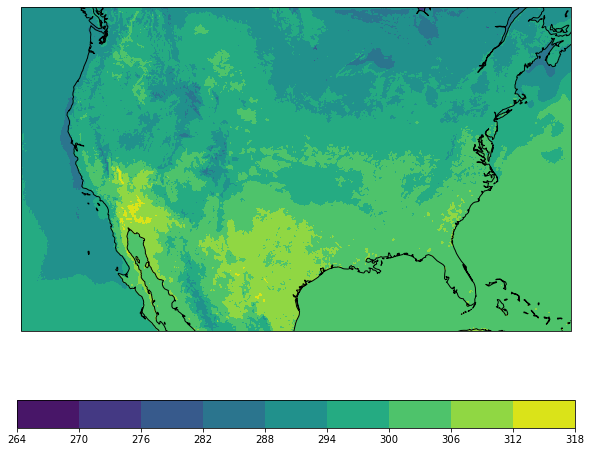

In [13]:
avg_TMP = ds.TMP.mean(dim='time')
fig = plt.figure(figsize=(10, 8.5))
ax = fig.add_subplot(1, 1, 1, projection=projection)
temp_plot = ax.contourf(avg_TMP.projection_x_coordinate, avg_TMP.projection_y_coordinate, avg_TMP)
ax.coastlines()
fig.colorbar(temp_plot, orientation="horizontal")

plt.show()

### Using Intake with Dask
Often times the data we want to analyze is too big to be loaded into memory all at once on your computer. [Dask]() solves this problem by breaking up your data into smaller chunks, operating on each chunck of data, and then aggregating the results. This is usually done in parallel on a cluster system. You can use Intake to create a Dask dataset by using the `to_dask` method instead of the `read` method.

In [14]:
ds1 = cat.hrrrzarr(date=dt.datetime(2021, 1, 1)).read()
print(type(ds1.TMP.data))

ds2 = cat.hrrrzarr(date=dt.datetime(2022, 1, 1)).to_dask()
print(type(ds2.TMP.data))

<class 'numpy.ndarray'>
<class 'dask.array.core.Array'>


As you can see [Xarray](https://foundations.projectpythia.org/core/xarray.html) uses Dask arrays instead of [NumPy](https://foundations.projectpythia.org/core/numpy.html) arrays to hold the data when the `to_dask` method is used.

---

## Summary
- Intake makes it easy to consistently access data regardless of where and how it is stored
- Intake catalogs contain useful information about the data they make available
- Intake can load data into Dask for use in parallel computing. 

### What's next?
In the next notebook we will look at writing a Intake catalog and making it available on [Github](https://foundations.projectpythia.org/foundations/getting-started-github.html).

## Resources and references

- [HRRR Zarr Example Using XArray (Mesowest)](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.html)
- [Intake Documentation](https://intake.readthedocs.io/en/latest/index.html)
- [NOAA High-Resolution Rapid Refresh (HRRR) Data Archive](https://mesowest.utah.edu/html/hrrr/)
- [HRRR Zarr Variable List](https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html)